# Stance Detection using Demonitisation Twitter DataSet and LSTM Model

In [89]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

file = "H:\Project Files\stance-detection\Dataset-Demonitization\csv_files/demoapril.csv"

df = pd.read_csv(file,encoding='utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2817 entries, 0 to 2816
Data columns (total 3 columns):
ID        2817 non-null object
text      2814 non-null object
Stance    2811 non-null object
dtypes: object(3)
memory usage: 66.1+ KB


## Tweet Preprocessing

In [90]:
import re
import nltk
from nltk.corpus import stopwords

df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str(text)
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#     text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

df['text'] = df.text + ' ' + 'Demonitization'
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].str.replace('\d+', '')

In [91]:
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 6540 unique tokens.


In [92]:
from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', X.shape)

Shape of data tensor: (2817, 100)


In [93]:
Y = pd.get_dummies(df['Stance']).values

print('Shape of label tensor:', Y.shape)

Shape of label tensor: (2817, 3)


In [94]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2535, 100) (2535, 3)
(282, 100) (282, 3)


## LSTM Model - 1

In [95]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

print(model.summary())

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 100, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 303       
Total params: 5,080,703
Trainable params: 5,080,703
Non-trainable params: 0
_________________________________________________________________
None
Train on 2281 samples, validate on 254 samples
Epoch 1/5
2281/2281 [==============================] - 16s 7ms/step - loss: 1.0664 - acc: 0.4244 - val_loss: 0.9976 - val_acc: 0.5669
Epoch 2/5
2281/2281 [==============================] - 11s 5ms/step - loss: 0.

In [96]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

282/282 [==============================] - 0s 778us/step
Test set
  Loss: 0.705
  Accuracy: 0.723


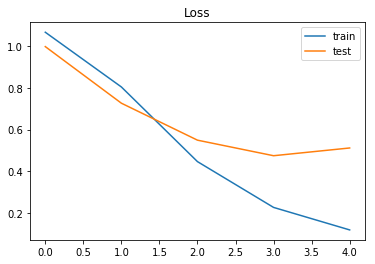

In [97]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

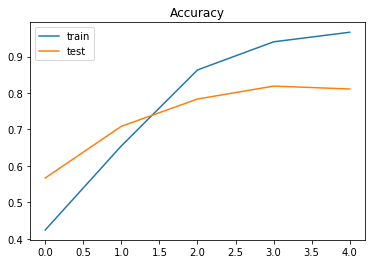

In [98]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

## CNN + LSTM Model - 2

In [99]:
from keras.layers import Embedding
from keras.models import Sequential, Model
from keras.layers import Dense, Activation
from keras.layers import Flatten, Conv1D, SpatialDropout1D, MaxPooling1D,AveragePooling1D, Bidirectional, merge, concatenate, Input, Dropout, LSTM

y_dim=3
num_filters=200
filter_sizes=[3,4,5] 
pool_padding='valid' 
dropout=0.5

embed_input = Input(shape=(X.shape[1],))
x = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1])(embed_input)
pooled_outputs = []
for i in range(len(filter_sizes)):
    conv = Conv1D(num_filters, kernel_size=filter_sizes[i], padding='valid', activation='relu')(x)
    conv = MaxPooling1D(pool_size=EMBEDDING_DIM-filter_sizes[i]+1)(conv)           
    pooled_outputs.append(conv)
merge = concatenate(pooled_outputs)
    
x = Dense(30, activation='relu')(merge)
x = Dropout(dropout)(x)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.5, recurrent_dropout=0.1))(x)
x = Dense(30, activation='relu')(x)
x = Dropout(dropout)(x)
x = Flatten()(x)
x = Dense(y_dim, activation='sigmoid')(x)

model = Model(inputs=embed_input,outputs=x)

#   model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['acc'])
model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

print(model.summary())

epochs = 3
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 100, 100)     5000000     input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 98, 200)      60200       embedding_16[0][0]               
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 97, 200)      80200       embedding_16[0][0]               
__________________________________________________________________________________________________
conv1d_22 

In [103]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

282/282 [==============================] - 0s 1ms/step
Test set
  Loss: 0.503
  Accuracy: 0.757


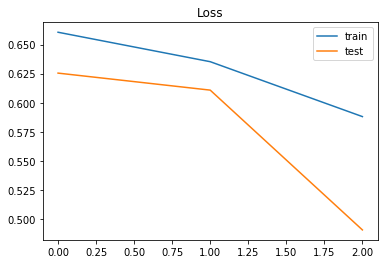

In [104]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

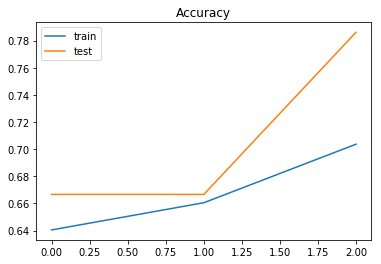

In [102]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();